# Optical Character Recognition (ORC)

# 1. Character Recognition using Tesseract

In [61]:
import cv2
import numpy as np
import pytesseract 
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression
# The path to tesseract we have installed
pytesseract.pytesseract.tesseract_cmd = r"E:\ML\OCR\tesseract.exe"

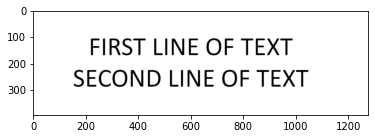

In [62]:
image="image1.jpg"
image = cv2.imread(image)
plt.imshow(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [63]:
text = pytesseract.image_to_string(image)
print(text)

FIRST LINE OF TEXT
SECOND LINE OF TEXT




# 2.Character Detection in image using OpenCV

In [130]:
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2

In [131]:
image="image2.jpg"
min_confidence=0.3
width=320
height=320
east="frozen_east_text_detection.pb"

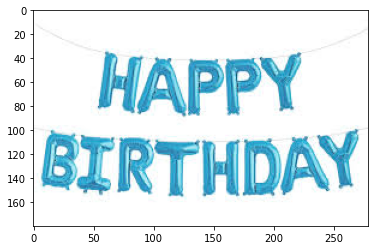

In [132]:
# load the input image and grab the image dimensions
image = cv2.imread(image)
plt.imshow(image)

In [133]:
orig = image.copy()
(H, W) = image.shape[:2]

In [134]:
(newW, newH) = (width, height)
rW = W / float(newW)
rH = H / float(newH)

In [135]:
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [136]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

In [137]:
# load the pre-trained EAST text detector
print("loading EAST text detector...")
net = cv2.dnn.readNet(east)

loading EAST text detector...


In [138]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

In [139]:
# show timing information on text prediction
print("text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

text detection took 0.253863 seconds


In [140]:
# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < min_confidence:
            continue
        
        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)
        
        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
        
        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
        
        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
        
        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [141]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [142]:
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    
    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

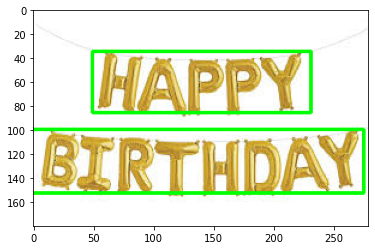

In [143]:
# show the output image
#cv2.imshow("Text Detection", orig)
#cv2.waitKey(0)

#cv2.destroyAllWindows()
orig=cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(orig)

# 3. Character Recognition using Deep learning and Opencv

In [78]:
from imutils.object_detection import non_max_suppression
import numpy as np
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"E:\ML\OCR\tesseract.exe"

In [79]:
def decode_predictions(scores, geometry):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the
        # geometrical data used to derive potential bounding box
        # coordinates that surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        
        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability,
            # ignore it
            if scoresData[x] < min_confidence:
                continue
                
            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            
            # extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            # use the geometry volume to derive the width and height
            # of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            
            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            
            # add the bounding box coordinates and probability score
            # to our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
            
    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)

In [80]:
image="image3.jpg"
east="frozen_east_text_detection.pb"
min_confidence=0.5
width=320
height=320
padding=0.3

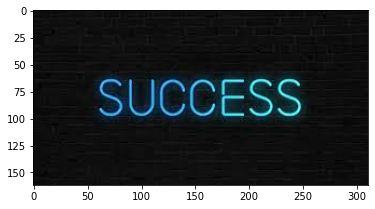

In [81]:
# load the input image and grab the image dimensions
image = cv2.imread(image)
plt.imshow(image)

In [82]:
orig = image.copy()
(origH, origW) = image.shape[:2]

In [83]:
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (width, height)
rW = origW / float(newW)
rH = origH / float(newH)

In [84]:
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [85]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

In [86]:
# load the pre-trained EAST text detector
print("loading EAST text detector...")
net = cv2.dnn.readNet(east)

loading EAST text detector...


In [87]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

In [88]:
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [89]:
# initialize the list of results
results = []

In [90]:
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    
    # in order to obtain a better OCR of the text we can potentially
    # apply a bit of padding surrounding the bounding box -- here we
    # are computing the deltas in both the x and y directions
    dX = int((endX - startX) * padding)
    dY = int((endY - startY) * padding)
    
    # apply padding to each side of the bounding box, respectively
    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX * 2))
    endY = min(origH, endY + (dY * 2))
    
    # extract the actual padded ROI
    roi = orig[startY:endY, startX:endX]
    
    # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(roi, config=config)
    
    # add the bounding box coordinates and OCR'd text to the list
    # of results
    results.append(((startX, startY, endX, endY), text))

# sort the results bounding box coordinates from top to bottom
results = sorted(results, key=lambda r:r[0][1])

In [91]:
# loop over the results
for ((startX, startY, endX, endY), text) in results:
    # display the text OCR'd by Tesseract
    print("OCR TEXT")
    print("========")
    print("{}\n".format(text))
    
    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV, then draw the text and a bounding box surrounding
    # the text region of the input image
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    output = orig.copy()
    cv2.rectangle(output, (startX, startY), (endX, endY),
                  (0, 0, 255), 2)
    cv2.putText(output, text, (startX, startY - 18),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)
    
    # show the output image
    #cv2.imshow("Text Detection", output)
    #cv2.waitKey(0)
    
#cv2.destroyAllWindows()

OCR TEXT
SUCCESS





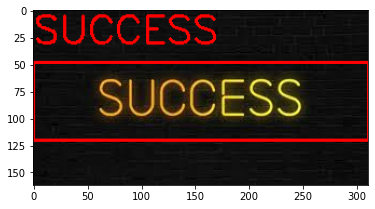

In [92]:
output=cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output)